In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import random
import os,time

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import sys

sys.path.append ("..")
from LSTM模型 import keras_model  # 导入
model = keras.models.load_model(r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\一回路温度控制\best_model.hdf5')

data_path=r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\一回路温度控制\一回路温度train数据.npy'
train_data=np.load(data_path,allow_pickle=True)
train_data=train_data.astype('float64')
men_std=np.load("一回路温度mean,std数据.npy",allow_pickle=True)
men_std[0]

array([7.73895844e+00, 2.61572654e+02, 2.63953474e+02, 4.56612677e+00,
       3.53780148e+01, 1.76500712e+02, 2.62570725e+01, 1.01088743e+02,
       1.06785439e+00, 2.46672616e-02, 8.40632707e-01, 1.46415121e+01])

In [56]:
fff=pd.DataFrame()
data=[]
for i in range(10000):
	aaa = float(tf.clip_by_value(tf.random.normal([1],-1.1,3.5),-1.11,6.5))
	data.append(aaa)

<AxesSubplot:ylabel='Frequency'>

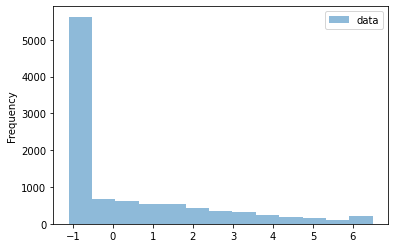

In [57]:
fff["data"]=data
fff.plot.hist(bins=13, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

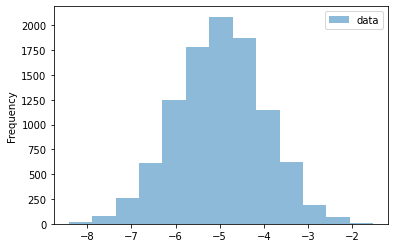

In [31]:
fff=pd.DataFrame()
data=[]
for i in range(10000):
	aaa = float(tf.random.normal([1],-5,1))
	data.append(aaa)

fff["data"]=data
fff.plot.hist(bins=13, alpha=0.5)

In [19]:
train_data[0]

array([[ 2.69183203,  1.91655899,  2.35629792,  1.24940039, -1.86650263,
        -3.12581857, -1.69267536, -3.03596508, -1.12381861, -1.38653583,
        -1.68733414, -1.11451727],
       [ 2.69102277,  1.91737342,  2.35612837,  1.24941672, -1.86650263,
        -3.12581857, -1.69696042, -3.03596508, -1.12272887, -1.38675354,
        -1.6865283 , -1.11451727],
       [ 2.68838387,  1.9172741 ,  2.35599273,  1.24944789, -1.86650263,
        -3.12581857, -1.70177133, -3.03596508, -1.12142411, -1.38725116,
        -1.68565531, -1.11451727],
       [ 2.68535794,  1.91709532,  2.35585709,  1.2494954 , -1.86650263,
        -3.12581857, -1.7051949 , -3.03596508, -1.12003997, -1.38717341,
        -1.68484948, -1.11451727],
       [ 2.68338756,  1.91713505,  2.35572145,  1.24955032, -1.86650263,
        -3.12581857, -1.70810382, -3.03596508, -1.11863801, -1.38669133,
        -1.68404364, -1.11451727],
       [ 2.68148755,  1.91723437,  2.35563668,  1.24961267, -1.86650263,
        -3.12581857, -

In [ ]:
def get_str_time ():
	s = '_'
	for i in time.localtime (time.time ())[0:6]:
		s += str (i) + '_'
	return s




class SGTR_env ():
	def __init__ (self,model,set_point,train_datasets,mean,std):
		self.action_space = np.array ([0] * 1)
		self.observation_space = np.array ([0] * 11)
		self.mean = mean
		self.std = std
		self.response = []
		self.set_point = set_point
		self.train_datasets = train_datasets
		self.model = model
		self.state = self.train_datasets[random.randint (0,train_datasets.shape[0])]
		self.step_count = 0  # 步数计数

	def reset (self):
		self.step_count = 0
		# begin_index = [2500,6500,11000,14500]
		begin_index = range(1800, self.train_datasets.shape[0]-3000,100)
		state = self.train_datasets[random.sample(begin_index,1)[0]]  # 10420]
		#  state = self.train_datasets[random.randint(0, self.train_datasets.shape[0]-1)]
		self.state = np.array (state)
		return np.array (state)

	def cal_origin_val (self,pos,now_val):
		"""
		计算未归一化的值
		"""
		val = now_val * self.std[pos] + self.mean[pos]
		return val

	def justice_down (self,next_state,step):
		"""
		判断是否达到失败条件，deltaT<10或70分钟内未能实现一二回路压力平衡（小于1MP）
		"""
		ori_deltaT = self.cal_origin_val (6,next_state[-1,6])
		# ori_pressure = self.cal_origin_val(0,next_state[-1, 0])
		if ori_deltaT < 10:  # or (step>4200 and ori_pressure<1):
			return True

		else:
			return False

	def cal_reward (self,speed):
		# if speed < 29.276 and speed > -141.276:
		# 	reward = -0.001 * speed ** 2 - 0.112 * speed + 4.136
		# elif speed < -141.276:
		# 	reward = 0.01 * speed + 1.2
		# else:
		# 	reward = -0.2 * speed + 6
		if speed <= -56:
			mu,sigma = -56,5
			reward = (1 / (math.sqrt (2 * math.pi) * sigma) * math.e ** (
						-(speed - mu) ** 2 / (2 * sigma ** 2))) * 37 - 0.5

		elif -10 >= speed > -56:
			reward = (-1 / 23) * speed + (1 / 2 - 10 / 23)
		elif speed > -10:
			reward = (-1 / 20) * speed  # +(19/42)
		else:
			print ("计算奖励错误")

		return reward

	def step (self,action):
		self.step_count += 1
		self.state[-1,-1] = action
		# model(test_input, training=False)
		next_variable_state = np.array (self.model (np.array ([self.state]),training=False))
		next_action = action
		zip_state_action = np.append (next_variable_state,next_action).reshape (1,-1)
		next_state = np.row_stack ((self.state,zip_state_action))
		next_state = np.delete (next_state,0,axis=0)
		ori_temp_last = self.cal_origin_val (1,next_state[-1,1])
		ori_temp_before_last = self.cal_origin_val (1,next_state[-2,1])
		temp_change_speed = (ori_temp_last - ori_temp_before_last) * 3600
		reward = self.cal_reward (temp_change_speed)
		done = self.justice_down (next_state,self.step_count)
		self.state = next_state

		return next_state,reward,done,{}


# import tensorflow_probability as tfp
# import tensorlayer as tl
#
# tfd = tfp.distributions
# Normal = tfd.Normal
#
# tl.logging.set_verbosity(tl.logging.DEBUG)

# random.seed (2)
# np.random.seed (2)
# tf.random.set_seed (2)  # reproducible

#####################  hyper parameters  ####################
# choose env
ENV = 'Pendulum-v0'
action_range = 1.  # scale action, [-action_range, action_range]

# RL training
max_frames = 4e6  # total number of steps for training
test_frames = 300  # total number of steps for testing
max_steps = 2000  # maximum number of steps for one episode
batch_size = 64  # udpate batchsize
explore_frams = 100  # 500 for random action sampling in the beginning of training
update_itr = 3  # repeated updates for single step
hidden_dim = 32  # size of hidden layers for networks
q_lr = 3e-4  # q_net learning rate
policy_lr = 3e-4  # policy_net learning rate
policy_target_update_interval = 3  # delayed steps for updating the policy network and target networks
explore_noise_scale = 1.0  # range of action noise for exploration
eval_noise_scale = 0.5  # range of action noise for evaluation of action value
reward_scale = 1.  # value range of reward
replay_buffer_size = 30000  # size of replay buffer


###############################  TD3  ####################################


class ReplayBuffer:
	'''
	a ring buffer for storing transitions and sampling for training
	:state: (state_dim,)
	:action: (action_dim,)
	:reward: (,), scalar
	:next_state: (state_dim,)
	:done: (,), scalar (0 and 1) or bool (True and False)
	'''

	def __init__ (self,capacity):
		self.capacity = capacity  # buffer的最大值
		self.buffer = []  # buffer列表
		self.position = 0  # 当前输入的位置，相当于指针

	def push (self,state,action,reward,next_state):
		# 如果buffer的长度小于最大值，也就是说，第一环的时候，需要先初始化一个“空间”，这个空间值为None，再给这个空间赋值。
		if len (self.buffer) < self.capacity:
			self.buffer.append (None)
		self.buffer[self.position] = (state,action,reward,next_state)
		self.position = int ((self.position + 1) % self.capacity)  # as a ring buffer

	def sample (self,batch_size):
		batch = random.sample (self.buffer,batch_size)
		state,action,reward,next_state = map (np.stack,zip (*batch))  # stack for each element
		'''
		the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
		zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
		the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
		np.stack((1,2)) => array([1, 2])
		'''
		return state,action,reward,next_state

	def __len__ (self):
		return len (self.buffer)


# 在代码中没有用到，但我们可以学习下，这里是直接修改gym环境的动作输出，把输出归一化。
# class NormalizedActions(gym.ActionWrapper):
# 	''' normalize the actions to be in reasonable range '''
#
# 	def _action(self, action):
# 		low = self.action_space.low  #动作空间最小值
# 		high = self.action_space.high  #动作空间最大值
#
# 		action = low + (action + 1.0) * 0.5 * (high - low)
# 		action = np.clip(action, low, high)
#
# 		return action
#
# 	def _reverse_action(self, action):
# 		low = self.action_space.low
# 		high = self.action_space.high
#
# 		action = 2 * (action - low) / (high - low) - 1
# 		action = np.clip(action, low, high)
#
# 		return action


class QNetwork ():
	''' the network for evaluate values of state-action pairs: Q(s,a) '''

	def __init__ (self,num_inputs,num_actions,hidden_dim,init_w = 3e-3):
		super (QNetwork,self).__init__ ()
		self.input_dim = num_inputs + num_actions
		self.net = self.get_net ()

	# w_init = tf.keras.initializers.glorot_normal(seed=None)
	# w_init = tf.random_uniform_initializer(-init_w, init_w)
	#
	# self.linear1 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=input_dim, name='q1')
	# self.linear2 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=hidden_dim, name='q2')
	# self.linear3 = Dense(n_units=1, W_init=w_init, in_channels=hidden_dim, name='q3')

	def get_net (self,name = 'Q_model'):
		inputs = keras.layers.Input (shape=[self.input_dim],name='C_input')
		x = keras.layers.Dense (64,activation='tanh',name='C_l1') (inputs)
		# x = keras.layers.BatchNormalization()(x)
		x = keras.layers.Dense (32,activation='tanh',name='C_l2') (x)
		# x = keras.layers.BatchNormalization()(x)
		x = keras.layers.Dense (1,name='C_out') (x)
		net = keras.Model (inputs=[inputs],outputs=[x],name='Critic' + name)
		return net


# def forward(self, input):
#     x = self.tanh1(input)
#     x = self.tanh2(x)
#     x = self.tanh3(x)
#     return x


class PolicyNetwork ():
	''' the network for generating non-determinstic (Gaussian distributed) action from the state input '''

	def __init__ (self,num_inputs,num_actions,hidden_dim,action_range = 1.,init_w = 3e-3):
		super (PolicyNetwork,self).__init__ ()
		get_custom_objects ().update ({'swish': Activation (self.self_act)})

		self.num_inputs = num_inputs
		self.action_range = action_range
		self.num_actions = num_actions
		self.net = self.get_net ()

	# w_init = tf.keras.initializers.glorot_normal(seed=None)
	# w_init = tf.random_uniform_initializer(-init_w, init_w)

	# self.tanh1 = keras.layers.Dense(hidden_dim, activation='rtanh',
	#                                   name='policy1')  #Dense(n_units=hidden_dim, act=tf.nn.rtanh, W_init=w_init, in_channels=num_inputs, name='policy1')
	# self.tanh2 = keras.layers.Dense(hidden_dim, activation='rtanh',
	#                                   name='policy2')  #Dense(n_units=hidden_dim, act=tf.nn.rtanh, W_init=w_init, in_channels=hidden_dim, name='policy2')
	# self.tanh3 = keras.layers.Dense(hidden_dim, activation='rtanh',
	#                                   name='policy3')  #Dense(n_units=hidden_dim, act=tf.nn.rtanh, W_init=w_init, in_channels=hidden_dim, name='policy3')
	#
	# self.output_tanh = keras.layers.Dense(num_actions,activation='tanh',
	#                                         name='policy_output')  #Dense(n_units=num_actions, W_init=w_init, b_init=tf.random_uniform_initializer(-init_w, init_w), in_channels=hidden_dim, name='policy_output')

	def get_net (self,name = 'policy_model'):
		"""
		Build actor network
		:param input_state_shape: state
		:param name: name
		:return: act
		"""
		inputs = keras.layers.Input (shape=[self.num_inputs],name='A_input')
		# x = keras.layers.BatchNormalization()(inputs)
		x = keras.layers.Dense (64,activation='tanh',name='policy1') (inputs)
		# x = keras.layers.BatchNormalization()(x)
		x = keras.layers.Dense (32,activation='tanh',name='policy2') (x)
		# x = keras.layers.BatchNormalization()(x)
		x = keras.layers.Dense (1,activation='sigmoid',name='policy3') (x)
		# x = keras.layers.Dense(self.num_actions, activation='swish', name='policy_output')(x)
		x = keras.layers.Lambda (lambda x: (np.array (action_max - action_min) * (x) + action_min)) (
			x)  # 注意这里，先用tanh把范围限定在[-1,1]之间，再进行映射

		net = keras.Model (inputs=[inputs],outputs=[x],name='Actor' + name)
		return net

	def self_act (self,x):
		# print(x)
		return tf.clip_by_value (x,action_min,action_max)  # 1/(1+tf.math.exp(-x))


# def forward(self, state):
#     #x = self.linear0(state)
#     x = self.linear1(state)
#     x = self.linear2(x)
#     x = self.linear3(x)
#
#     output = self.output_linear(x)  # unit range output [-1, 1]
#
#     return output

# def evaluate(self, state, eval_noise_scale):
#     '''
#     generate action with state for calculating gradients;
#     eval_noise_scale: as the trick of target policy smoothing, for generating noisy actions.
#     '''
#     state = state.astype(np.float32)        #状态的type整理
#     action = self.forward(state)            #通过state计算action，注意这里action范围是[-1,1]
#
#     #action = self.action_range * action     #映射到游戏的action取值范围
#
#     # add noise
#     # normal = Normal(0, 1)                   #建立一个正态分布
#     # eval_noise_clip = 2 * eval_noise_scale  #对噪声进行上下限裁剪。eval_noise_scale
#     # noise = normal.sample(action.shape) * eval_noise_scale      #弄个一个noisy和action的shape一致，然后乘以scale
#     # noise = tf.clip_by_value(noise, -eval_noise_clip, eval_noise_clip)  #对noisy进行剪切，不要太大也不要太小
#     # action = action + noise                 #action加上噪音
#
#     return action

# 输入state，输出action
def get_action (self,state,explore_noise_scale):
	''' generate action with state for interaction with envronment '''
	action = self.net.predict (state)  # 这里的forward函数，就是输入state，然后通过state输出action。只不过形式不一样而已。最后的激活函数式tanh，所以范围是[-1, 1]
	# print(action,type(action))
	action = action.numpy ()[0]  # 获得的action变成矩阵。

	# add noise
	# normal = Normal(0, 1)                   #生成normal这样一个正态分布
	# noise = normal.sample(action.shape) * explore_noise_scale       #在正态分布中抽样一个和action一样shape的数据，然后乘以scale
	# action = self.action_range * action + noise     #action乘以动作的范围，加上noise

	return action


def sample_action (self):
	''' generate random actions for exploration '''
	a = tf.random.uniform ([self.num_actions],action_min,action_max)

	return a.numpy ()


class TD3_Trainer ():

	def __init__ (
			self,replay_buffer,hidden_dim,action_range,policy_target_update_interval = 1,q_lr = 3e-4,policy_lr = 3e-4
	):
		self.replay_buffer = replay_buffer

		# initialize all networks
		# 用两个Qnet来估算，doubleDQN的想法。同时也有两个对应的target_q_net
		self.q_net1 = QNetwork (state_dim,action_dim,hidden_dim).net
		self.q_net2 = QNetwork (state_dim,action_dim,hidden_dim).net
		self.target_q_net1 = QNetwork (state_dim,action_dim,hidden_dim).net
		self.target_q_net2 = QNetwork (state_dim,action_dim,hidden_dim).net
		self.policy_net = PolicyNetwork (state_dim,action_dim,hidden_dim,action_range).net
		self.target_policy_net = PolicyNetwork (state_dim,action_dim,hidden_dim,action_range).net
		print ('Q Network (1,2): ',self.q_net1)
		print ('Policy Network: ',self.policy_net)

		# initialize weights of target networks
		# 把net 赋值给target_network
		self.target_q_net1.set_weights (
			self.q_net1.get_weights ())  # = self.target_ini(self.q_net1, self.target_q_net1)
		self.target_q_net2.set_weights (
			self.q_net2.get_weights ())  # = self.target_ini(self.q_net2, self.target_q_net2)
		self.target_policy_net.set_weights (
			self.policy_net.get_weights ())  # = self.target_ini(self.policy_net, self.target_policy_net)

		self.update_cnt = 0  # 更新次数
		self.policy_target_update_interval = policy_target_update_interval  # 策略网络更新频率

		self.q_optimizer1 = tf.optimizers.Adam (q_lr)
		self.q_optimizer2 = tf.optimizers.Adam (q_lr)
		self.policy_optimizer = tf.optimizers.Adam (policy_lr)

	# 在网络初始化的时候进行硬更新
	def target_ini (self,net,target_net):
		''' hard-copy update for initializing target networks '''
		for target_param,param in zip (target_net.trainable_weights,net.trainable_weights):
			target_param.assign (param)
		return target_net

	# 在更新的时候进行软更新
	def target_soft_update (self,net,target_net,soft_tau):
		''' soft update the target net with Polyak averaging '''
		for target_param,param in zip (target_net.trainable_weights,net.trainable_weights):
			target_param.assign (  # copy weight value into target parameters
				target_param * (1.0 - soft_tau) + param * soft_tau
				# 原来参数占比 + 目前参数占比
			)
		return target_net

	def update (self,batch_size,eval_noise_scale,reward_scale = 10.,gamma = 0.9,soft_tau = 1e-3):
		''' update all networks in TD3 '''
		self.update_cnt += 1  # 计算更新次数
		state,action,reward,next_state = self.replay_buffer.sample (batch_size)  # 从buffer sample数据

		reward = reward[:,np.newaxis]  # expand dim， 调整形状，方便输入网络

		# 输入s',从target_policy_net计算a'。注意这里有加noisy的
		##改：此处为不加噪音，后续可与加入噪音进行对比
		new_next_action = self.target_policy_net.predict (next_state)  # clipped normal noise#到底裁不裁？？？？？？？？？？？？？？？？？？？

		# 归一化reward.(有正有负)
		# reward = reward_scale * (reward - np.mean(reward, axis=0)) / (np.std(reward, axis=0) + 1e-6)  # normalize with batch mean and std; plus a small number to prevent numerical problem

		# Training Q Function
		# 把s'和a'堆叠在一起，一起输入到target_q_net。
		# 有两个qnet，我们取最小值

		target_q_input = tf.concat ([next_state,new_next_action],1)  # the dim 0 is number of samples
		target_q_min = tf.minimum (self.target_q_net1.predict (target_q_input),
		                           self.target_q_net2.predict (target_q_input))

		# 计算target_q的值，用于更新q_net
		# 之前有把done从布尔变量改为int，就是为了这里能够直接计算。
		target_q_value = reward + gamma * target_q_min  # if done==1, only reward
		state = state.astype ('float32')
		action = action.astype ('float32')
		action = action.reshape (64,1)
		q_input = tf.concat ([state,action],1)  # input of q_net

		q_input = tf.dtypes.cast (q_input,tf.float32)
		# 更新q_net1
		# 这里其实和DQN是一样的
		with tf.GradientTape () as q1_tape:
			predicted_q_value1 = self.q_net1 (q_input)
			q_value_loss1 = tf.reduce_mean (tf.square (predicted_q_value1 - target_q_value))
		q1_grad = q1_tape.gradient (q_value_loss1,self.q_net1.trainable_weights)
		self.q_optimizer1.apply_gradients (zip (q1_grad,self.q_net1.trainable_weights))

		# 更新q_net2
		with tf.GradientTape () as q2_tape:
			predicted_q_value2 = self.q_net2 (q_input)
			q_value_loss2 = tf.reduce_mean (tf.square (predicted_q_value2 - target_q_value))
		q2_grad = q2_tape.gradient (q_value_loss2,self.q_net2.trainable_weights)
		self.q_optimizer2.apply_gradients (zip (q2_grad,self.q_net2.trainable_weights))

		# Training Policy Function
		# policy不是经常update的，而qnet更新一定次数，才update一次
		policy_loss_rec = False
		if self.update_cnt % self.policy_target_update_interval == 0:
			# 更新policy_net
			with tf.GradientTape () as p_tape:
				# 计算 action = Policy(s)，注意这里是没有noise的
				new_action = self.policy_net (
					state
				)  # no noise, deterministic policy gradients

				# 叠加state和action
				new_q_input = tf.concat ([state,new_action],1)
				# ''' implementation 1 '''
				# predicted_new_q_value = tf.minimum(self.q_net1(new_q_input),self.q_net2(new_q_input))
				''' implementation 2 '''
				predicted_new_q_value = self.q_net1 (new_q_input)
				policy_loss = -tf.reduce_mean (predicted_new_q_value)  # 梯度上升
				policy_loss_rec = policy_loss
			p_grad = p_tape.gradient (policy_loss,self.policy_net.trainable_weights)
			self.policy_optimizer.apply_gradients (zip (p_grad,self.policy_net.trainable_weights))
			# print(self.policy_net.)

			# Soft update the target nets
			# 软更新target_network三个
			self.target_q_net1 = self.target_soft_update (self.q_net1,self.target_q_net1,soft_tau)
			self.target_q_net2 = self.target_soft_update (self.q_net2,self.target_q_net2,soft_tau)
			self.target_policy_net = self.target_soft_update (self.policy_net,self.target_policy_net,soft_tau)

		if policy_loss_rec:
			return q_value_loss1,q_value_loss2,policy_loss_rec
		else:
			return q_value_loss1,q_value_loss2,10086

	def save_weights (self,model_path,describe = ''):  # save trained weights
		save_path = os.path.join (model_path,describe)
		if not os.path.exists (save_path):
			os.makedirs (save_path)
		self.q_net1.save (save_path + '/model_q_net1.hdf5')
		self.q_net2.save (save_path + '/model_q_net2.hdf5')
		self.target_q_net1.save (save_path + '/model_target_q_net1.hdf5')
		self.target_q_net2.save (save_path + '/model_target_q_net2.hdf5')
		self.policy_net.save (save_path + '/model_policy_net.hdf5')
		self.target_policy_net.save (save_path + '/model_target_policy_net.hdf5')
		return save_path

	# tl.files.save_npz(self.q_net1.trainable_weights, name='model_q_net1.npz')
	# tl.files.save_npz(self.q_net2.trainable_weights, name='model_q_net2.npz')
	# tl.files.save_npz(self.target_q_net1.trainable_weights, name='model_target_q_net1.npz')
	# tl.files.save_npz(self.target_q_net2.trainable_weights, name='model_target_q_net2.npz')
	# tl.files.save_npz(self.policy_net.trainable_weights, name='model_policy_net.npz')
	# tl.files.save_npz(self.target_policy_net.trainable_weights, name='model_target_policy_net.npz')

	def load_weights (self,save_path):  # load trained weights
		self.q_net1.load_weights (save_path + '/model_q_net1.hdf5')
		self.q_net2.load_weights (save_path + '/model_q_net2.hdf5')
		self.target_q_net1.load_weights (save_path + '/model_target_q_net1.hdf5')
		self.target_q_net2.load_weights (save_path + '/model_target_q_net2.hdf5')
		self.policy_net.load_weights (save_path + '/model_policy_net.hdf5')
		self.target_policy_net.load_weights (save_path + '/model_target_policy_net.hdf5')


# tl.files.load_and_assign_npz(name='model_q_net1.npz', network=self.q_net1)
# tl.files.load_and_assign_npz(name='model_q_net2.npz', network=self.q_net2)
# tl.files.load_and_assign_npz(name='model_target_q_net1.npz', network=self.target_q_net1)
# tl.files.load_and_assign_npz(name='model_target_q_net2.npz', network=self.target_q_net2)
# tl.files.load_and_assign_npz(name='model_policy_net.npz', network=self.policy_net)
# tl.files.load_and_assign_npz(name='model_target_policy_net.npz', network=self.target_policy_net)

# 初始化环境
action_max ,action_min=6.5,-1.11
model_name = get_str_time ()
env = SGTR_env (model=model,set_point=-56,train_datasets=train_data,mean=men_std[0],std=men_std[1])  # 环境
action_dim = env.action_space.shape[0]  # 动作空间
state_dim = env.observation_space.shape[0]

# 初始化缓冲区
replay_buffer = ReplayBuffer (replay_buffer_size)

# 初始化agent
td3_trainer = TD3_Trainer (replay_buffer,hidden_dim=hidden_dim,
                           policy_target_update_interval=policy_target_update_interval,action_range=action_range,
                           q_lr=q_lr,policy_lr=policy_lr)
rewards=[]


def fill_replay_buff():
	global replay_buffer
	with open (
			r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\replay_buff_\numpy_binary.npy',
			'rb') as f:
		buff_data = np.load (f,allow_pickle=True)
	buff_datas = buff_data.tolist ()
	print('Filling Replay Buffer.......')
	for data in tqdm(buff_datas):
		state,action,reward,next_state = data
		replay_buffer.push(state,action,reward,next_state)




def train (new:bool,thread_name:str):
	global model_name,env,action_dim,state_dim,replay_buffer,td3_trainer,rewards
	print("initializing.......")
	if not new:
		fill_replay_buff ()
		# 接着上一次训练
		td3_trainer.load_weights (
			r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\rl_model\last_model\_2022_7_23_21_3_4_96_0')
		# 获得上一次的奖励
		reward_data = pd.read_csv (r"M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\rewards_recoard\_2022_7_23_21_3_4_rewards.csv")
		reward = reward_data["rewards"].values.tolist ()
	else:
		reward=[]

	frame_idx = 0  # 总步数
	rewards = reward  # 记录每个EP的总reward
	max_reward = 0  # 记录最大reward
	# time_spend = []
	# t0 = time.time ()
	# t_start = time.time ()
	try:
		while frame_idx < max_frames:
			# 小于最大步数，就继续训练
			# time_temp = {"frame_idx": frame_idx}

			state = env.reset ()[-1]  # 初始化state
			state = state.astype (np.float32)  # 整理state的类型
			episode_reward = 0
			# time_temp["初始化state"] = time.time () - t0

			step_count = 0
			# 开始训练

			for step in range (max_steps):
				t0 = time.time ()
				if frame_idx > explore_frams:  # 如果小于500步，就随机，如果大于就用get-action
					action = td3_trainer.policy_net.predict (
						np.array ([state])) + tf.clip_by_value (tf.random.normal ([1],0,0.006),-1,1)
					action = action.numpy().tolist()[0][0]
				else:
					#指数分布随机
					# action = tf.clip_by_value (random.expovariate (1 / 0.878413) - 0.878413,action_min,
					#                            action_max)  # tf.random.uniform([1], action_min, action_max)+tf.clip_by_value(tf.random.normal([1],0,0.006),-1,1)
					# action=action.numpy()
					# 平均分布随机
					aaa = tf.random.uniform ([1],-1,1)
					action=(action_max-action_min) * aaa.numpy().tolist()[0]
				#time_temp["选择action"] = time.time () - t0

				# 与环境进行交互
				# t0 = time.time ()
				next_state,reward,done,_ = env.step (action)
				if frame_idx > explore_frams:
					reward += random.random () / 10
				next_state = next_state.astype (np.float32)
				action = np.array (action).tolist ()
				done = 1 if done == True else 0
				#time_temp["与环境交互"] = time.time () - t0

				# 记录数据在replay_buffer
				# t0 = time.time ()
				replay_buffer.push (state,action,reward,next_state)

				# 赋值state，累计总reward，步数
				state = next_state
				episode_reward += reward
				# time_temp["记录数据"] = time.time () - t0

				print (f'Thread:{thread_name} | Episode: {frame_idx}/{max_frames}  | Action: {action} | Step: {step} | Step Reward: {round(reward,3)} |',end='\r')

				if done:
					step_count = step
					break

				# 如果数据超过一个batch_size的大小，那么就开始更新
				t0 = time.time ()
				if len (replay_buffer) >= 29999 and step_count>100:
					for i in range (1):  # 注意：这里更新可以更新多次！
						td3_trainer.update (batch_size,eval_noise_scale=0.1,reward_scale=0.1)
				# time_temp["td3网络更新"] = time.time () - t0
				# time_spend.append (time_temp)
				step_count = step


			print(
				'Thread:{} | Episode: {}/{}  | Episode Reward: {:.4f}  | Run Step: {} |--------Process Failed Flag-------'.format (
					thread_name,frame_idx,max_frames,episode_reward,step_count))

			frame_idx += 1

			# t0 = time.time ()
			if step_count > 100 and episode_reward > max_reward:  # 保存奖励最大的模型
				max_reward = episode_reward
				td3_trainer.save_weights ('rl_model/best_model',model_name+str(frame_idx)+"_"+str(max_reward))
			# print (f"模型保存：{time.time () - t0}\n#################")
			# print(episode_reward,'###',state)
			rewards.append (episode_reward)

	except:
		rewards_rec = pd.DataFrame (data={'rewards': rewards})
		rewards_rec.to_csv (r"rewards_recoard/" + model_name + 'rewards.csv')
		td3_trainer.save_weights ('rl_model/last_model',model_name+str(frame_idx)+"_"+str(max_reward))
		replay_data = np.array (replay_buffer.buffer,dtype='object')
		np.save ("replay_buff_/numpy_binary",replay_data)

	rewards_rec = pd.DataFrame (data={'rewards': rewards})
	rewards_rec.to_csv (r"rewards_recoard/" + model_name + 'rewards.csv')
	td3_trainer.save_weights ('rl_model/last_model',model_name + str (frame_idx) + "_" + str (max_reward))
	replay_data = np.array (replay_buffer.buffer,dtype='object')
	np.save ("replay_buff_/numpy_binary",replay_data)






def test ():
	global model_name,env,action_dim,state_dim,replay_buffer,td3_trainer
	# 装载模型权重
	td3_trainer.load_weights (
		r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\rl_model\last_model\_2022_7_23_11_28_26_794_76.59812447160093')
	for test_count in range(10):
		state = env.reset ()[-1]  # 初始化state
		state = state.astype (np.float32)  # 整理state的类型
		speed_rec = []
		temp_rec = []
		action_rec = []
		reward_sum=[]
		episode_reward=0
		for step in tqdm (range (max_steps)):
			action = td3_trainer.policy_net.predict (
				np.array ([state]))  # + tf.clip_by_value (tf.random.normal ([1],0,0.006),-1,1)
			action = action.data.tolist ()[0][0]
			action_rec.append (action)
			# 与环境进行交互
			next_state,reward,done,_ = env.step (action)
			next_state = next_state.astype (np.float32)
			action = np.array (action).tolist ()
			done = 1 if done == True else 0
			print(reward)
			episode_reward+=reward
			reward_sum.append(episode_reward)

			ori_temp_before_last = env.cal_origin_val (1,state[1])
			ori_temp_last = env.cal_origin_val (1,next_state[1])
			temp_rec.append (ori_temp_before_last)
			# 赋值state，累计总reward，步数
			state = next_state

			temp_change_speed = (ori_temp_last - ori_temp_before_last) * 3600
			speed_rec.append (temp_change_speed)
		plt.subplot (2,2,1)
		plt.plot (speed_rec)
		plt.title ('speed_rec')
		plt.subplot (2,2,2)
		plt.plot (temp_rec)
		plt.title ('temp_rec')
		plt.subplot (2,2,3)
		plt.plot (action_rec)
		plt.title ('action_rec')
		plt.subplot (2,2,4)
		plt.plot (reward_sum)
		plt.title ('reward_sum')
		plt.show ()


def plot_reward():
	global env
	temp = []
	xlist = []
	for i in range (int (10000 / 0.01)):
		xlist.append (-5000 + 0.01 * i)

	for i in xlist:
		aaa = env.cal_reward (i)
		temp.append (aaa)
	plt.plot (xlist,temp)
	plt.show ()


if __name__ == '__main__':
	# def multi_thread ():
	# 	threads = []
	# 	for i in range(10):
	# 		threads.append (
	# 			threading.Thread (target=train,args=(True,f"Thread{i}"))
	# 		)
	#
	# 	for thread in threads:
	# 		thread.start ()
	#
	# 	for thread in threads:
	# 		thread.join ()
	#
	# try:
	# 	multi_thread()
	# except:
	# 	rewards_rec = pd.DataFrame (data={'rewards': rewards})
	# 	rewards_rec.to_csv (r"rewards_recoard/" + model_name + 'rewards.csv')
	# 	td3_trainer.save_weights ('rl_model/last_model',model_name)
	# 	replay_data = np.array (replay_buffer.buffer,dtype='object')
	# 	np.save ("numpy_binary",replay_data)

	#train(True,"Thread0")


	train(True,"Thread0")

In [3]:

import sys

sys.path.append("..")
from tensorflow import keras
import numpy as np
import random

import math

import os
import time

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

import tensorlayer as tl


def get_str_time():
    s = '_'
    for i in time.localtime(time.time())[0:6]:
        s += str(i) + '_'
    return s


model = keras.models.load_model(
    r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\一回路温度控制\温度模型\模型\best_model_epoch42.hdf5')
#

data_path = r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\一回路温度控制\一回路温度train数据.npy'
train_data = np.load(data_path, allow_pickle=True)
train_data = train_data.astype('float64')
men_std = np.load("一回路温度mean,std数据.npy", allow_pickle=True)


def get_str_time():
    s = '_'
    for i in time.localtime(time.time())[0:6]:
        s += str(i) + '_'
    return s


class SGTR_env():
    def __init__(self, model, set_point, train_datasets, mean, std):
        self.action_space = np.array([0] * 1)
        self.observation_space = np.array([0] * 12)
        self.mean = mean
        self.std = std
        self.response = []
        self.set_point = set_point
        self.train_datasets = train_datasets
        self.model = model
        self.state = self.train_datasets[8000]  # [random.randint(0, train_datasets.shape[0])]
        self.step_count = 0  # 步数计数

    def reset(self):
        self.step_count = 0
        # begin_index = range(1800, self.train_datasets.shape[0] - 3000, 100)
        state = self.train_datasets[8000]
        #  state = self.train_datasets[random.randint(0, self.train_datasets.shape[0]-1)]
        self.state = np.array(state)
        return np.array(state).reshape(120, )

    def cal_origin_val(self, pos, now_val):
        """
		计算未归一化的值
		"""
        val = now_val * self.std[pos] + self.mean[pos]
        return val

    def justice_down(self, error):
        """
		判断是否达到失败条件，deltaT<10或70分钟内未能实现一二回路压力平衡（小于1MP）
		"""
        # ori_deltaT = self.cal_origin_val(6, next_state[-1, 6])
        # ori_pressure = self.cal_origin_val(0,next_state[-1, 0])
        # if ori_deltaT < 7.9 and step > 100:  # or (step>4200 and ori_pressure<1):
        #     return True
        #
        # else:
        #     return False
        if abs(error) > 1:
            return True
        else:
            return False

    def cal_reward(self, error):
        if error > -0.01 and error < 0.01:
            reward_1 = 2
        else:
            reward_1 = 0
        reward_2 = -2*abs(error)
        reward = reward_1 + reward_2
        return reward

    def step(self, action):
        self.step_count += 1
        self.state[-1, -1] = action
        # model(test_input, training=False)
        next_variable_state = np.array(self.model(np.array([self.state]), training=False))
        next_action = action
        zip_state_action = np.append(next_variable_state, next_action).reshape(1, -1)
        next_state = np.row_stack((self.state, zip_state_action))
        next_state = np.delete(next_state, 0, axis=0)
        # ori_temp_last = self.cal_origin_val(1, next_state[-1, 1])
        # ori_temp_before_last = self.cal_origin_val(1, next_state[-2, 1])
        error = self.set_point - next_state[-1, 1]
        reward = self.cal_reward(error)
        done = self.justice_down(error)
        self.state = next_state

        return np.array(next_state).reshape(1,120 ), reward, done, {}


# import tensorflow_probability as tfp
# import tensorlayer as tl
#
# tfd = tfp.distributions
# Normal = tfd.Normal
#
# tl.logging.set_verbosity(tl.logging.DEBUG)

random.seed(2)
np.random.seed(2)

#####################  hyper parameters  ####################
RANDOMSEED = 1  # random seed

EP_MAX = 1000  # total number of episodes for training
EP_LEN = 500  # total number of steps for each episode
GAMMA = 0.9  # reward discount
A_LR = 0.0001  # learning rate for actor
C_LR = 0.0002  # learning rate for critic
BATCH = 32  # update batchsize
A_UPDATE_STEPS = 10  # actor update steps
C_UPDATE_STEPS = 10  # critic update steps
S_DIM, A_DIM = 120, 1  # state dimension, action dimension
EPS = 1e-8  # epsilon

# 注意：这里是PPO1和PPO2的相关的参数。
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),  # KL penalty  PPO1
    dict(name='clip', epsilon=0.2),  # Clipped surrogate objective, find this is better  PPO2
][1]  # choose the method for optimization


# METHOD=METHOD[1]
###############################  PPO  ####################################

class PPO(object):
    '''
    PPO 类
    '''

    def __init__(self):

        # 构建critic网络：
        # 输入state，输出V值
        tfs = tl.layers.Input([None, S_DIM], tf.float32, 'state')
        l1 = tl.layers.Dense(100, tf.nn.relu)(tfs)
        v = tl.layers.Dense(1)(l1)
        self.critic = tl.models.Model(tfs, v)
        self.critic.train()

        # 构建actor网络：
        # actor有两个actor 和 actor_old， actor_old的主要功能是记录行为策略的版本。
        # 输入是state，输出是描述动作分布的mu和sigma
        self.actor = self._build_anet('pi', trainable=True)
        self.actor_old = self._build_anet('oldpi', trainable=False)
        self.actor_opt = tf.optimizers.Adam(A_LR)
        self.critic_opt = tf.optimizers.Adam(C_LR)

    def a_train(self, tfs, tfa, tfadv):
        '''
        更新策略网络(policy network)
        '''
        # 输入时s，a，td-error。这个和AC是类似的。
        tfs = np.array(tfs, np.float32)  # state
        tfa = np.array(tfa, np.float32)  # action
        tfadv = np.array(tfadv, np.float32)  # td-error

        with tf.GradientTape() as tape:

            # 【敲黑板】这里是重点！！！！
            # 我们需要从两个不同网络，构建两个正态分布pi，oldpi。
            mu, sigma = self.actor(tfs)
            pi = tfp.distributions.Normal(mu, sigma)

            mu_old, sigma_old = self.actor_old(tfs)
            oldpi = tfp.distributions.Normal(mu_old, sigma_old)

            # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
            # 在新旧两个分布下，同样输出a的概率的比值
            # 除以(oldpi.prob(tfa) + EPS)，其实就是做了import-sampling。怎么解释这里好呢
            # 本来我们是可以直接用pi.prob(tfa)去跟新的，但为了能够更新多次，我们需要除以(oldpi.prob(tfa) + EPS)。
            # 在AC或者PG，我们是以1,0作为更新目标，缩小动作概率到1or0的差距
            # 而PPO可以想作是，以oldpi.prob(tfa)出发，不断远离（增大or缩小）的过程。
            ratio = pi.prob(tfa) / (oldpi.prob(tfa) + EPS)
            # 这个的意义和带参数更新是一样的。
            surr = ratio * tfadv

            # 我们还不能让两个分布差异太大。
            # PPO1
            if METHOD['name'] == 'kl_pen':
                tflam = METHOD['lam']
                kl = tfp.distributions.kl_divergence(oldpi, pi)
                kl_mean = tf.reduce_mean(kl)
                aloss = -(tf.reduce_mean(surr - tflam * kl))
            # PPO2：
            # 很直接，就是直接进行截断。
            else:  # clipping method, find this is better
                aloss = -tf.reduce_mean(
                    tf.minimum(ratio * tfadv,  # surr
                               tf.clip_by_value(ratio, 1. - METHOD['epsilon'], 1. + METHOD['epsilon']) * tfadv)
                )
        a_gard = tape.gradient(aloss, self.actor.trainable_weights)

        self.actor_opt.apply_gradients(zip(a_gard, self.actor.trainable_weights))

        if METHOD['name'] == 'kl_pen':
            return kl_mean

    def update_old_pi(self):
        '''
        更新actor_old参数。
        '''
        for p, oldp in zip(self.actor.trainable_weights, self.actor_old.trainable_weights):
            oldp.assign(p)

    def c_train(self, tfdc_r, s):
        '''
        更新Critic网络
        '''
        tfdc_r = np.array(tfdc_r, dtype=np.float32)  # tfdc_r可以理解为PG中就是G，通过回溯计算。只不过这PPO用TD而已。

        with tf.GradientTape() as tape:
            v = self.critic(s)
            advantage = tfdc_r - v  # 就是我们说的td-error
            closs = tf.reduce_mean(tf.square(advantage))

        grad = tape.gradient(closs, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(grad, self.critic.trainable_weights))

    def cal_adv(self, tfs, tfdc_r):
        '''
        计算advantage，也就是td-error
        '''
        tfdc_r = np.array(tfdc_r, dtype=np.float32)
        advantage = tfdc_r - self.critic(tfs)  # advantage = r - gamma * V(s_)
        return advantage.numpy()

    def update(self, s, a, r):
        '''
        Update parameter with the constraint of KL divergent
        :param s: state
        :param a: act
        :param r: reward
        :return: None
        '''
        s, a, r = s.astype(np.float32), a.astype(np.float32), r.astype(np.float32)

        self.update_old_pi()
        adv = self.cal_adv(s, r)
        # adv = (adv - adv.mean())/(adv.std()+1e-6)  # sometimes helpful

        # update actor
        #### PPO1比较复杂:
        # 动态调整参数 adaptive KL penalty
        if METHOD['name'] == 'kl_pen':
            for _ in range(A_UPDATE_STEPS):
                kl = self.a_train(s, a, adv)
                if kl > 4 * METHOD['kl_target']:  # this in in google's paper
                    break
            if kl < METHOD['kl_target'] / 1.5:  # adaptive lambda, this is in OpenAI's paper
                METHOD['lam'] /= 2
            elif kl > METHOD['kl_target'] * 1.5:
                METHOD['lam'] *= 2
            METHOD['lam'] = np.clip(
                METHOD['lam'], 1e-4, 10
            )  # sometimes explode, this clipping is MorvanZhou's solution

        #### PPO2比较简单，直接就进行a_train更新:
        # clipping method, find this is better (OpenAI's paper)
        else:
            for _ in range(A_UPDATE_STEPS):
                self.a_train(s, a, adv)

        # 更新 critic
        for _ in range(C_UPDATE_STEPS):
            self.c_train(r, s)

    def _build_anet(self, name, trainable):
        '''
        Build policy network
        :param name: name
        :param trainable: trainable flag
        :return: policy network
        '''
        # 连续动作型问题，输出mu和sigma。
        tfs = tl.layers.Input([None, S_DIM], tf.float32, name + '_state')
        l1 = tl.layers.Dense(100, tf.nn.relu, name=name + '_l1')(tfs)

        a = tl.layers.Dense(A_DIM, tf.nn.tanh, name=name + '_a')(l1)
        mu = tl.layers.Lambda(lambda x: x * 2, name=name + '_lambda')(a)

        sigma = tl.layers.Dense(A_DIM, tf.nn.softplus, name=name + '_sigma')(l1)

        model = tl.models.Model(tfs, [mu, sigma], name)

        if trainable:
            model.train()
        else:
            model.eval()
        return model

    def choose_action(self, s):
        '''
        Choose action
        :param s: state
        :return: clipped act
        '''
        s = s[np.newaxis, :].astype(np.float32)
        mu, sigma = self.actor(s)  # 通过actor计算出分布的mu和sigma
        pi = tfp.distributions.Normal(mu, sigma)  # 用mu和sigma构建正态分布
        a = tf.squeeze(pi.sample(1), axis=0)[0]  # 根据概率分布随机出动作
        return np.clip(a, -2, 2)  # 最后sample动作，并进行裁剪。

    def get_v(self, s):
        '''
        计算value值。
        '''
        s = s.astype(np.float32)
        if s.ndim < 2: s = s[np.newaxis, :]  # 要和输入的形状对应。
        return self.critic(s)[0, 0]

    def save_ckpt(self):
        """
        save trained weights
        :return: None
        """
        if not os.path.exists('model'):
            os.makedirs('model')
        tl.files.save_weights_to_hdf5('model/ppo_actor.hdf5', self.actor)
        tl.files.save_weights_to_hdf5('model/ppo_actor_old.hdf5', self.actor_old)
        tl.files.save_weights_to_hdf5('model/ppo_critic.hdf5', self.critic)

    def load_ckpt(self):
        """
        load trained weights
        :return: None
        """
        tl.files.load_hdf5_to_weights_in_order('model/ppo_actor.hdf5', self.actor)
        tl.files.load_hdf5_to_weights_in_order('model/ppo_actor_old.hdf5', self.actor_old)
        tl.files.load_hdf5_to_weights_in_order('model/ppo_critic.hdf5', self.critic)


def train():
    env = SGTR_env(model=model, set_point=0.0739, train_datasets=train_data, mean=men_std[0], std=men_std[1])

    # reproducible
    np.random.seed(RANDOMSEED)
    tf.random.set_seed(RANDOMSEED)

    ppo = PPO()

    all_ep_r = []

    # 更新流程：
    for ep in range(EP_MAX):
        s = env.reset()
        s=s.reshape(1,120)
        buffer_s, buffer_a, buffer_r = [], [], []
        ep_r = 0
        t0 = time.time()
        for t in range(EP_LEN):  # in one episode
            # env.render()
            a = ppo.choose_action(s)
            s_, r, done, _ = env.step(a)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)  # 对奖励进行归一化。有时候会挺有用的。所以我们说说，奖励是个主观的东西。
            s = s_
            ep_r += r

            # # N步更新的方法，每BATCH步了就可以进行一次更新
            if (t + 1) % BATCH == 0 or t == EP_LEN - 1:
                v_s_ = ppo.get_v(s_)  # 计算n步中最后一个state的v_s_

                # 和PG一样，向后回溯计算。
                discounted_r = []
                for r in buffer_r[::-1]:
                    v_s_ = r + GAMMA * v_s_
                    discounted_r.append(v_s_)
                discounted_r.reverse()

                # 所以这里的br并不是每个状态的reward，而是通过回溯计算的V值
                bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
                buffer_s, buffer_a, buffer_r = [], [], []
                ppo.update(bs, ba, br)

        if ep == 0:
            all_ep_r.append(ep_r)
        else:
            all_ep_r.append(all_ep_r[-1] * 0.9 + ep_r * 0.1)
        print(
            'Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                ep, EP_MAX, ep_r,
                time.time() - t0
            )
        )

    ppo.save_ckpt()




if __name__ == '__main__':


	from tqdm import tqdm
	env = SGTR_env(model=model, set_point=0.0739, train_datasets=train_data, mean=men_std[0], std=men_std[1])


	# reproducible
	np.random.seed(RANDOMSEED)
	tf.random.set_seed(RANDOMSEED)

	#ppo = PPO()

	step_r = []
	sum_r=[0]

	ppo.load_ckpt()
	s = env.reset().reshape(1,120)
	state=[s]
	for i in tqdm(range(1000)):
		# if i ==200:
		#     env.set_point=[-0.36,-0.23]
		s_, r, done, _ = env.step(ppo.choose_action(s))
		step_r.append(r)
		sum_r.append(r+sum_r[-1])
		state.append(s_)
		s=s_
		if done:
			break

[TL] [*] Load model/ppo_actor.hdf5 SUCCESS!
[TL] [*] Load model/ppo_actor_old.hdf5 SUCCESS!
[TL] [*] Load model/ppo_critic.hdf5 SUCCESS!


100%|██████████| 1000/1000 [00:09<00:00, 104.23it/s]


In [4]:
state=np.array(state)
#aaa,bbb,ccc,ddd=state[:,:,[4]],state[:,:,[5]],state[:,:,[6]],state[:,:,[7]]
eee,fff,ggg,hhh=state[:,:,[0]],state[:,:,[1]],state[:,:,[2]],state[:,:,[3]]

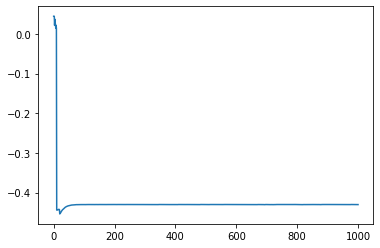

In [5]:
plt.plot(fff.reshape(1,1001).T)
plt.show()

In [7]:
np.array(fff.reshape(1,1001).T)


array([[ 0.04429093],
       [ 0.04429093],
       [ 0.04429093],
       ...,
       [-0.4300786 ],
       [-0.43009278],
       [-0.43007106]])